In [0]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

In [19]:
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras import models
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import optimizers
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np



'''
データの設定
'''
batch_size = 20

conv_base = VGG16(
    weights = "imagenet",           # モデルを初期化するための重みのチェックポイントを指定
    include_top = False,            # ネットワークの出力側にある全結合分類器を含めるかどうか
    input_shape = (150, 150, 3)     # ネットワークに供給する画像テンソルの形状 (引数を指定しない場合,ネットワークは任意のサイズの入力を処理できる)
)
# conv_base.summary()

datagen = ImageDataGenerator(rescale= 1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = "binary"
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:     # ジェネレータはデータを無限ループで生成するため、画像を一通り処理したらbreak
            break
    return features, labels

train_features, train_labels = extract_features("train", 2000)
validation_features, validation_labels = extract_features("validation", 1000)
test_features, test_labels = extract_features("test", 1000)
# (samples,4,4,512) を (samples, 4*4*512) に平坦化
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

'''
モデルの構築
'''

model = models.Sequential()
model.add(Dense(256, input_dim= 4*4*512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(
    optimizer= optimizers.RMSprop(lr=2e-5),
    loss= "binary_crossentropy",
    metrics= ["acc"]
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
'''
学習
'''
early_stopping = EarlyStopping(monitor= "val_loss", patience= 10, verbose= 1)
# batch_size = 32

history = model.fit(
    train_features, train_labels,
    epochs= 30,
    batch_size= batch_size,
    validation_data= (validation_features, validation_labels)
)
model.save("cats_and_dogs_small_3.h5")



Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 941us/step - loss: 0.6691 - acc: 0.6545 - val_loss: 0.4117 - val_acc: 0.8390
Epoch 2/30
2000/2000 [==============================] - 1s 498us/step - loss: 0.4675 - acc: 0.7715 - val_loss: 0.3827 - val_acc: 0.8370
Epoch 3/30
2000/2000 [==============================] - 1s 500us/step - loss: 0.3789 - acc: 0.8305 - val_loss: 0.3303 - val_acc: 0.8670
Epoch 4/30
2000/2000 [==============================] - 1s 506us/step - loss: 0.3286 - acc: 0.8590 - val_loss: 0.3398 - val_acc: 0.8520
Epoch 5/30
2000/2000 [==============================] - 1s 491us/step - loss: 0.2859 - acc: 0.8775 - val_loss: 0.3117 - val_acc: 0.8730
Epoch 6/30
2000/2000 [==============================] - 1s 488us/step - loss: 0.2550 - acc: 0.9000 - val_loss: 0.2783 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 1s 496us/step - loss: 0.2368 - acc: 0.9090 - val_loss: 0.2800 - val_acc: 0.8880


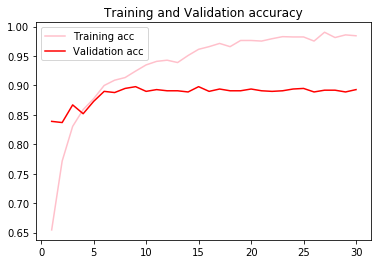

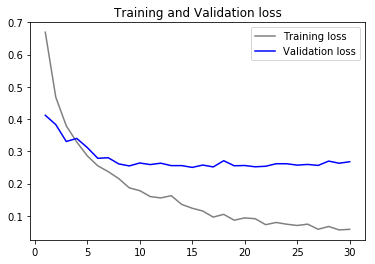

In [21]:
'''
評価
'''
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label="Training acc", color= "pink")
plt.plot(epochs, val_acc, label="Validation acc", color= "red")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, label="Training loss", color= "gray")
plt.plot(epochs, val_loss, label="Validation loss", color= "blue")
plt.title("Training and Validation loss")
plt.legend()

plt.show()